Scaler saved successfully!
Explained Variance Ratio: [0.26075043 0.12682289 0.09325892 0.05812951 0.0439073  0.03770489
 0.03388067 0.02844944 0.02426    0.02343457 0.01957918 0.01901901
 0.01712207 0.01616481 0.01464239]


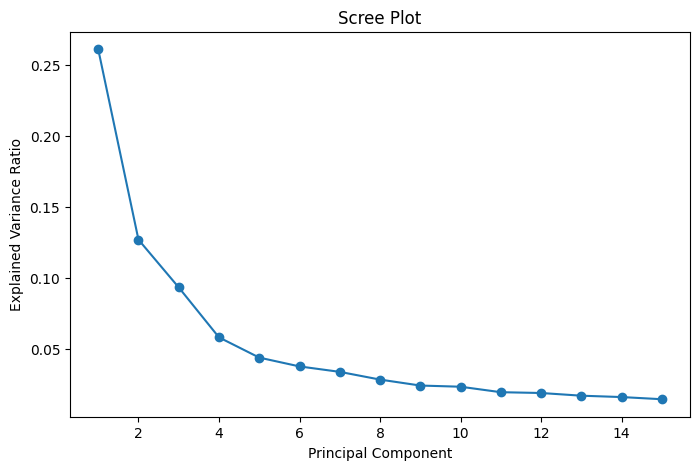

PCA model saved successfully!


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
df=pd.read_csv(r"D:\cbm_prj\features\features.csv")


# Standardize features (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['label']))
# Save the scaler
with open('classification_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler saved successfully!")

# Apply PCA
pca = PCA(n_components=15)  # Adjust components based on variance retention
principal_components = pca.fit_transform(scaled_data)

# Convert to DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15'])

# Explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Scree Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

# Save the PCA model
with open('classification_pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

print("PCA model saved successfully!")

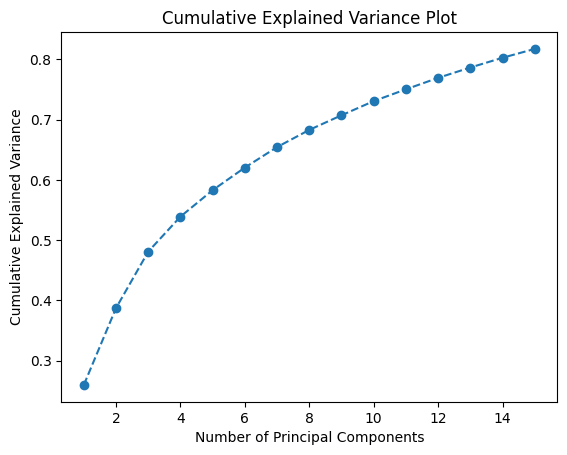

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the PCA model fitted
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Plot")
plt.show()


Model Accuracy: 0.9762331302997731

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12510
           1       0.96      0.96      0.96      6768
           2       0.95      0.93      0.94      2223
           3       1.00      0.99      0.99      2997
           4       0.99      0.82      0.90       471
           5       0.96      0.97      0.96      5814
           6       0.95      0.97      0.96      2709

    accuracy                           0.98     33492
   macro avg       0.97      0.95      0.96     33492
weighted avg       0.98      0.98      0.98     33492



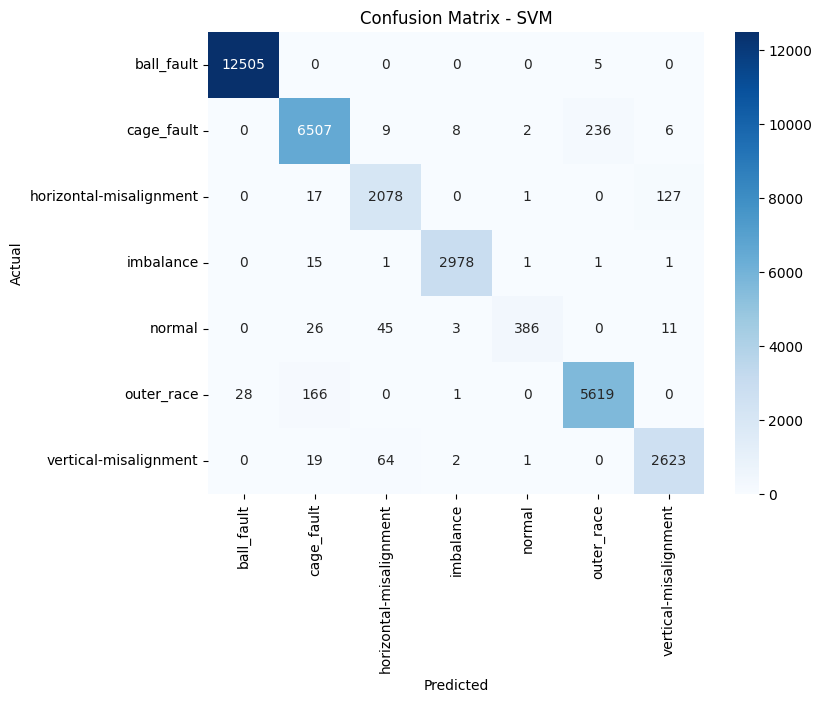

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the extracted feature dataset
features_combined = pd.read_csv(r"D:\cbm_prj\features\features.csv") # Uncomment if loading from a file

# Encode categorical labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
features_combined["Encoded_Label"] = label_encoder.fit_transform(features_combined["label"])

# Split features and target
X = pca_df
y = features_combined["Encoded_Label"]


# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM Model with RBF Kernel
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)

# Predict on Test Data
y_pred = svm_model.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()



In [27]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the extracted feature dataset
features_combined = pd.read_csv(r"D:\cbm_prj\features\features.csv") # Uncomment if loading from a file

# Encode categorical labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
features_combined["Encoded_Label"] = label_encoder.fit_transform(features_combined["label"])

# Split features and target
X = pca_df
y = features_combined["Encoded_Label"]


# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Apply SMOTE for class balance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Apply SMOTE for balancing B to J
X_resampled, y_resampled=SMOTE(random_state=42).fit_resample(X_train, y_train)

# Train LGBMClassifier (Multi-class)
multi_model = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    metric='multi_logloss',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    n_estimators=100,
    random_state=42,
    verbose = -1
)



multi_model.fit(X_resampled, y_resampled)



# Evaluate
y_pred_f = multi_model.predict(X_test)
accuracy_f = accuracy_score(y_test, y_pred_f)
print(f"Multi-class Model Accuracy: {accuracy_f:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_f))



Multi-class Model Accuracy: 0.9787

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12510
           1       0.97      0.96      0.96      6768
           2       0.96      0.95      0.95      2223
           3       0.99      0.99      0.99      2997
           4       0.85      0.93      0.89       471
           5       0.96      0.98      0.97      5814
           6       0.96      0.97      0.97      2709

    accuracy                           0.98     33492
   macro avg       0.96      0.97      0.96     33492
weighted avg       0.98      0.98      0.98     33492



In [28]:
import pickle
import os

# Create a directory to store models
os.makedirs('models', exist_ok=True)

# Save the trained LightGBM multi-class model
with open('models/classification_model.pkl', 'wb') as f:
    pickle.dump(multi_model, f)

# Save the StandardScaler
with open('models/classification_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the PCA model
with open('models/classification_pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

# Save the Label Encoder
with open('models/classification_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("All necessary files have been saved successfully!")


All necessary files have been saved successfully!


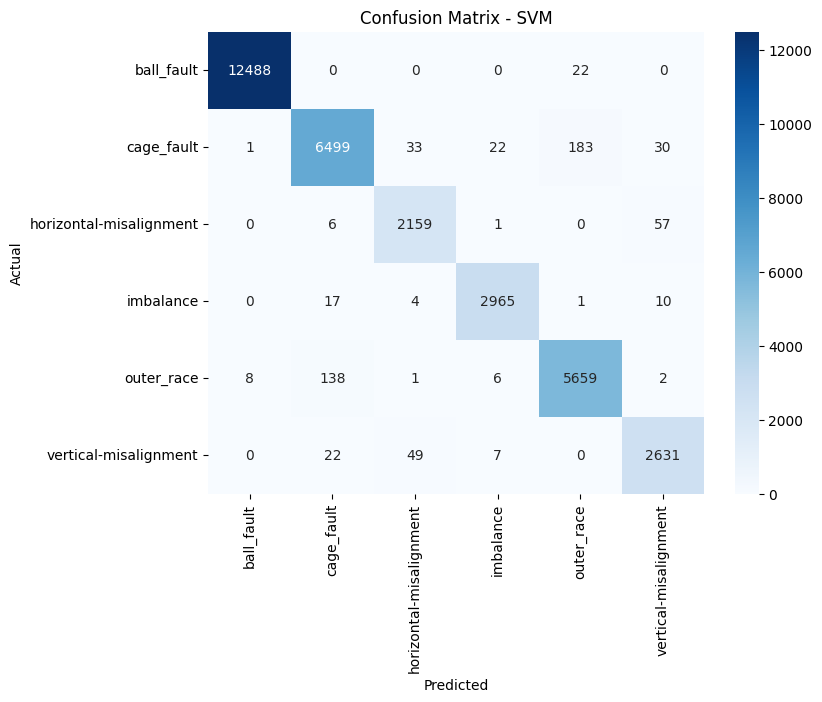

In [10]:
from sklearn.metrics import  confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_f), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()